# Palm 2 - Modeling - Linear Regression 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import math as math
import plotly.graph_objects as go

import time
import random
import seaborn as sns


import numpy as np
from os import path
from PIL import Image

from datetime import datetime
from dateutil import relativedelta
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from io import StringIO

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [2]:
# My Custom color and font scheme - to be used across all graphs 
my_title_col = 'darkslategray'
my_label_col = 'darkslategray'
my_graph_col = 'darkcyan'
my_title_font = 24
my_label_font = 20
my_ticks_font = 18
sns.color_palette("YlOrBr");

#### Define Functions 

In [197]:
# Functions 

def age_in_months(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    months = difference.years * 12 + difference.months
    return months

def age_in_years(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    years = difference.years
    return years

def age_from_to(from_date, to_date):
    difference = relativedelta.relativedelta(to_date, from_date)
    months = difference.years * 12 + difference.months
    return months




##### Build Scores function

In [4]:
# Function to catupre evalting metrics from different models
scores_df = pd.DataFrame
scores_df = pd.DataFrame(columns=['Model Type','Dataset','Metric','Score'],index=None)
scores_df.Score.astype(float)

def scores(scores_df,model,dataset,metric,score):
    scores_df = scores_df.append({'Model Type':model,
                'Dataset': dataset,
                'Metric': metric,
                'Score':score},
                ignore_index=True)
    return scores_df

In [5]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

## Modeling 

### Approach
- Monthly consolidated rain and crop data for entire estate will be used.
- Data from 1-Apr-2011 to 31-Dec-2019 will be used to train and validate
- Data from 1-Jan-2020 to 31-May-2020

### Review of target variable

In [6]:
#load final fused dataset
df = pd.read_csv("../data/final_fused.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = df.sort_values('date')

dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset

In [7]:
dfi.head()

,rain,crop
date,,
2011-04-30,243.377949,7994.20059
2011-05-31,93.778205,8614.03416
2011-06-30,67.302564,7714.13505
2011-07-31,119.758974,8511.76212
2011-08-31,5.344615,7345.95696


In [8]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2011-04-30 to 2019-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    105 non-null    float64
 1   crop    105 non-null    float64
dtypes: float64(2)
memory usage: 2.5 KB


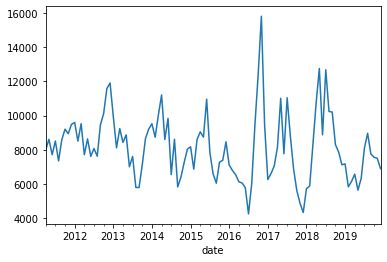

In [9]:
dfi['crop'].plot();

**Observation: Visually crop data has high variance however mean seams to remain in the same ballpark.**

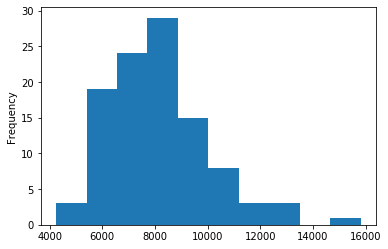

In [10]:
dfi['crop'].plot(kind='hist');

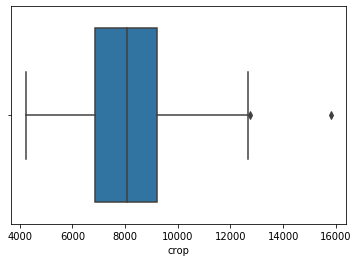

In [11]:
sns.boxplot(dfi['crop']);

In [12]:
dfi[dfi['crop']>13000]

,rain,crop
date,,
2016-11-30,593.846154,15805.64415


**Observation: Crop has one outlier at approx. 15000 tons per month.**

### Review Predictor - rain data

In [13]:
dfi.describe()

,rain,crop
count,105.000000,105.000000
mean,210.981370,8156.284809
std,124.378317,1919.317589
min,0.000000,4249.610610
25%,119.758974,6863.549750
50%,202.897436,8071.899680
75%,282.571795,9202.491790
max,593.846154,15805.644150


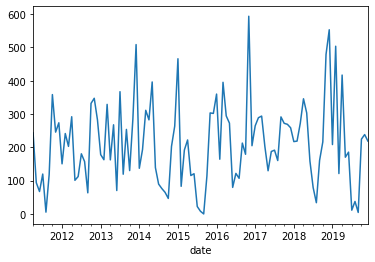

In [14]:
dfi['rain'].plot();

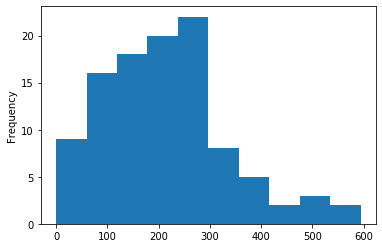

In [15]:
dfi['rain'].plot(kind='hist');

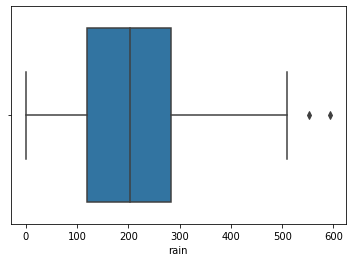

In [16]:
sns.boxplot(dfi['rain']);

In [17]:
dfi[dfi['rain']>500]

,rain,crop
date,,
2013-12-31,508.728205,9213.40346
2016-11-30,593.846154,15805.64415
2018-12-31,553.266667,7123.28892
2019-02-28,503.779487,5835.13835


**Observation: There are two outliers beyond 500mm of rain per month.**

### Linear Regression - Phase 1
In phase 1, final_fused.csv is used which contains monthly rain and crop data at estate level

#### Base Model

Scores are computed by predicting all values to be mean of the labelled target feature.

In [18]:
# compute mean of the traget variable 'crop'.
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset

dfi['y_preds'] =  dfi['crop'] 
crop_mean = dfi['crop'].mean()
dfi['y_preds'] = dfi['y_preds'].apply(lambda x: crop_mean)

y_val = dfi['crop']
y_preds = dfi['y_preds']

print(f'Mean : {crop_mean}')
print(f'RMSE of Base Model:{math.sqrt(metrics.mean_squared_error(y_val,y_preds))}')
scores_df = scores(scores_df,'Linear Regression Base Model','train_val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val,y_preds)),2)}')


Mean : 8156.28480933333
RMSE of Base Model:1910.1561165830115


#### Scenerio - 1

Only use 'rain' data for each month as predictor for that months crop

In [19]:
# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020


dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi_m_train = dfi[dfi.index < '2020-01-01'].copy() # train & val dataset
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test data
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # keeping data only until 31-may-2020

dfi_m_test.drop('crop',axis=1,inplace=True) # dropping target variable from test dataset

# Removing date as index for modeling
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['rain']]
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

# change datasets to same scale
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr1 = LinearRegression()

# fit the model with train dataset
lr1.fit(X_train_scaled, y_train)

# predict on val dataset
y_preds = lr1.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr1_S1','train','R2',f'{round(lr1.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','Val','R2',f'{round(lr1.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr1.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr1.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','train','CVal_3',f'{round(cross_val_score(lr1, X_train_scaled, y_train, cv=3).mean(),4)}')
scores_df.tail()

,Model Type,Dataset,Metric,Score
2,Linear Regression lr1_S1,Val,R2,-0.3052
3,Linear Regression lr1_S1,Val,Adj R2,-0.3574
4,Linear Regression lr1_S1,train,RMSE,2015.81
5,Linear Regression lr1_S1,Val,RMSE,1509.75
6,Linear Regression lr1_S1,train,CVal_3,-0.0686


#### Scenerio - 1 Evaluation

In [20]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

27

In [21]:
resd.mean()

-550.5059053033318

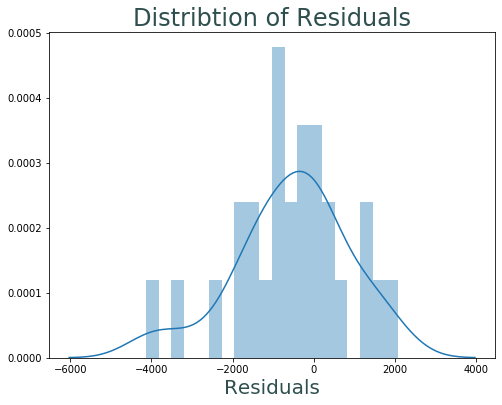

In [22]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

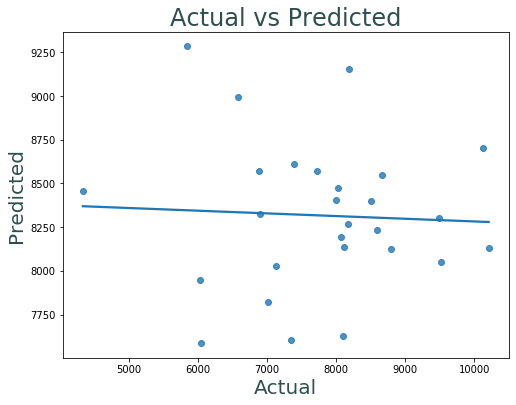

In [23]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

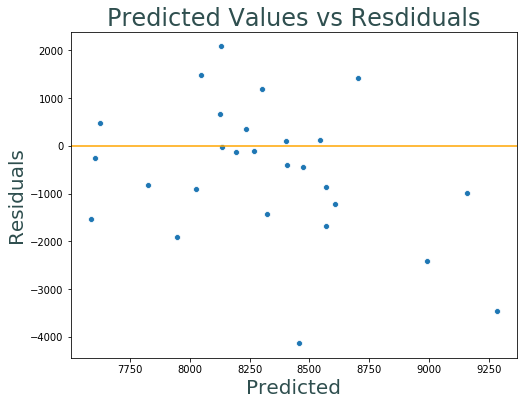

In [24]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 1 Conclusion

#### Scenerio - 2

- Use lag of rain data with 12 months and 24 months by adding and shifting rain_12 and rain_24 features
- remove original 'rain' feature since we will not have forecasted rain data in production

In [25]:
#For modeling from train and test datasets
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 12 months

dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['rain_12','rain_24']]
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr2 = LinearRegression()
# fit the model on train dataset
lr2.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr2.predict(X_val_scaled)

#storing scores
scores_df = scores(scores_df,'Linear Regression lr2_S2','Train','R2',f'{round(lr2.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','Val','R2',f'{round(lr2.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr2.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr2.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','train','CVal_10',f'{round(cross_val_score(lr2, X_train_scaled, y_train, cv=3).mean(),4)}')
scores_df.tail(6)

,Model Type,Dataset,Metric,Score
7,Linear Regression lr2_S2,Train,R2,0.0389
8,Linear Regression lr2_S2,Val,R2,-0.1747
9,Linear Regression lr2_S2,Val,Adj R2,-0.3052
10,Linear Regression lr2_S2,train,RMSE,1986.81
11,Linear Regression lr2_S2,Val,RMSE,2161.78
12,Linear Regression lr2_S2,train,CVal_10,-0.0578


#### Scenerio - 2 Evaluation

In [26]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

21

In [27]:
resd.mean()

-346.8237001494866

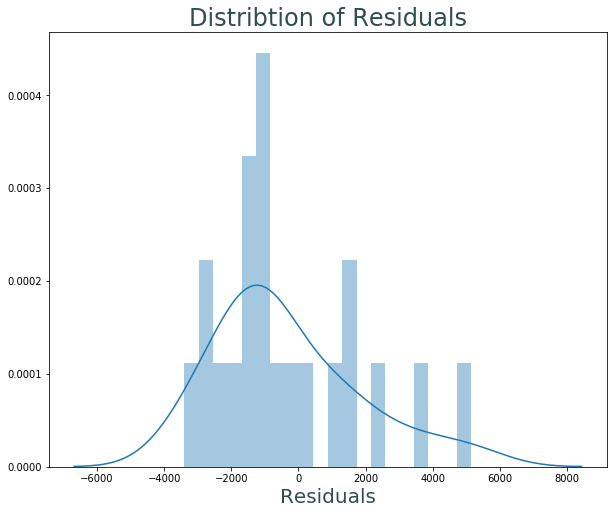

In [28]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

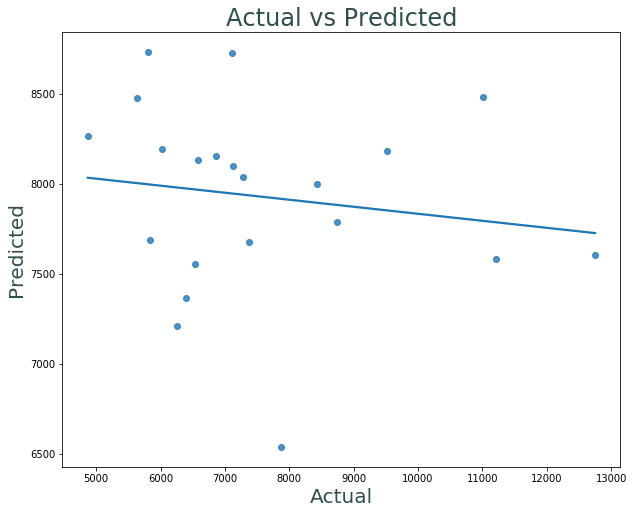

In [29]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

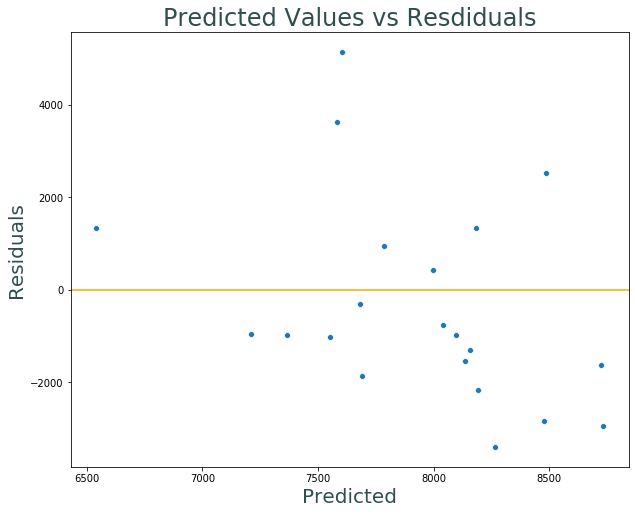

In [30]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 2 Conclusion

#### Scenerio - 3

- use lag of rain data with 12 months and 24 months by adding and shifting rain_12 and rain_24 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' in addition to rain_12 and rain_24

In [31]:
#For modeling from train and test datasets
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['month'] = dfi.index.month # adding new feature month

dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 12 months

dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['month','rain_12','rain_24']]
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr3 = LinearRegression()
# fit the model on train dataset
lr3.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr3.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr3_S3','Train','R2',f'{round(lr3.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','R2',f'{round(lr3.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr3.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr3.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','CVal_10',f'{round(-cross_val_score(lr3, X_val_scaled, y_val, cv=10).mean(),4)}')
scores_df.tail(6)



,Model Type,Dataset,Metric,Score
13,Linear Regression lr3_S3,Train,R2,0.0606
14,Linear Regression lr3_S3,Val,R2,-0.2543
15,Linear Regression lr3_S3,Val,Adj R2,-0.4757
16,Linear Regression lr3_S3,Train,RMSE,1964.2
17,Linear Regression lr3_S3,Val,RMSE,2233.86
18,Linear Regression lr3_S3,Val,CVal_10,1551.9196


#### Scenerio - 3 Evaluation

In [32]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

21

In [33]:
resd.mean()

-248.63503653615507

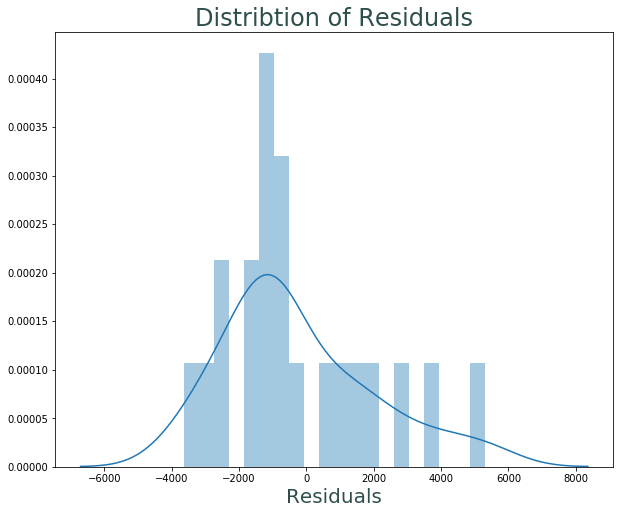

In [34]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

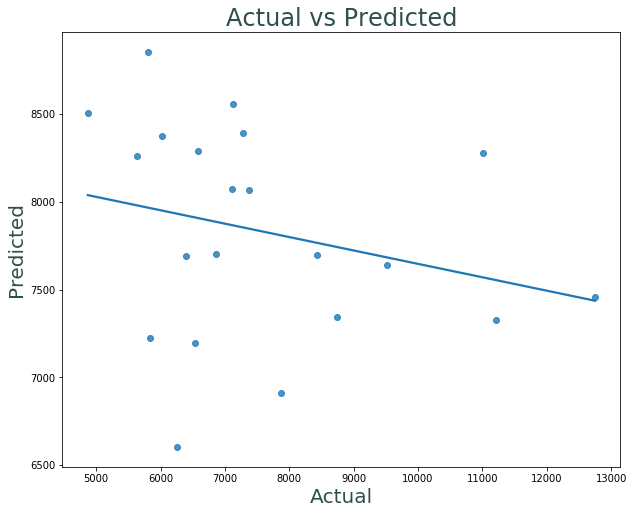

In [35]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

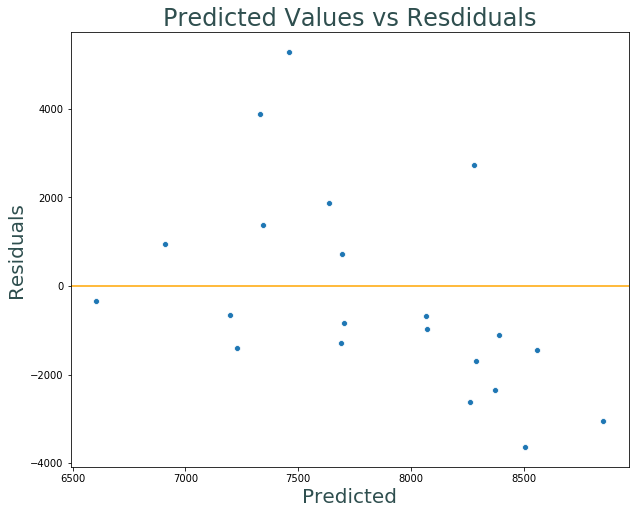

In [36]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 3 Conclusion

#### Scenerio - 4
- use lag of rain data with 12 months and 24 months by adding and shifting rain_12 and rain_24 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' in addition to rain_12 and rain_24
- Remove outliers from crop data in train_val dataset


In [37]:
#For modeling from train and test datasets
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['month'] = dfi.index.month # adding new feature month

dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 12 months

dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# remove outliers from Crop data in train & val 
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 15000].index,inplace=True) 

dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['month','rain_12','rain_24']]
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr4 = LinearRegression()
# fit the model on train dataset
lr4.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr4.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr4_S4','Train','R2',f'{round(lr4.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','R2',f'{round(lr4.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr4.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr4.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','CVal_3',f'{round(cross_val_score(lr4, X_val_scaled, y_val, cv=3).mean(),4)}')
scores_df.tail(6)

,Model Type,Dataset,Metric,Score
19,Linear Regression lr4_S4,Train,R2,0.0538
20,Linear Regression lr4_S4,Val,R2,-0.7329
21,Linear Regression lr4_S4,Val,Adj R2,-1.0579
22,Linear Regression lr4_S4,train,RMSE,1859.77
23,Linear Regression lr4_S4,Val,RMSE,1822.64
24,Linear Regression lr4_S4,Val,CVal_3,-0.304


#### Scenerio - 4 Evaluation

In [38]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

20

In [39]:
resd.mean()

-1029.7196575239088

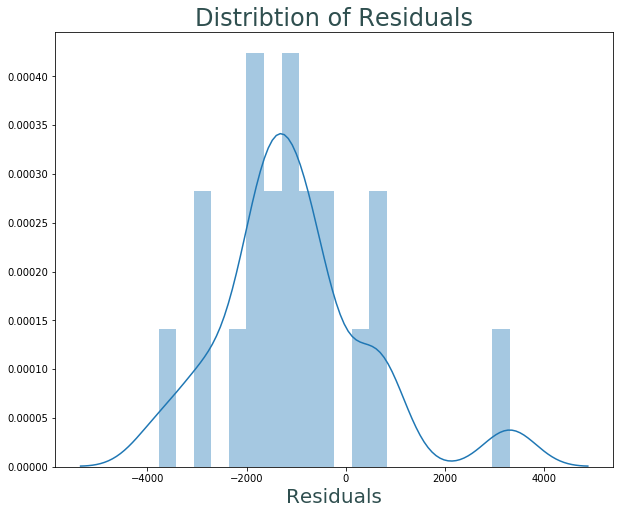

In [40]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

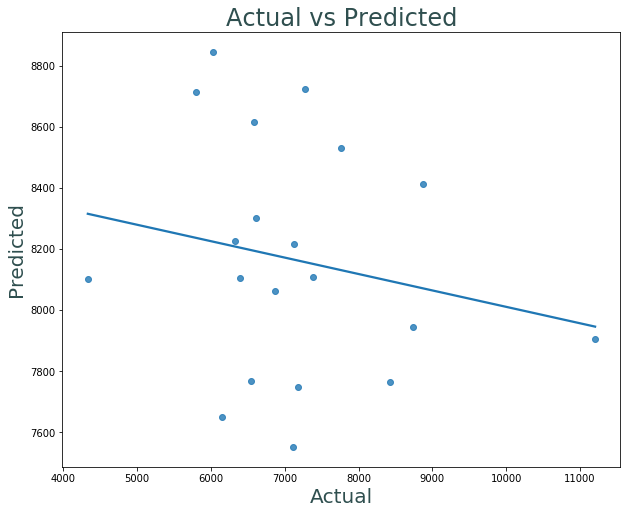

In [41]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

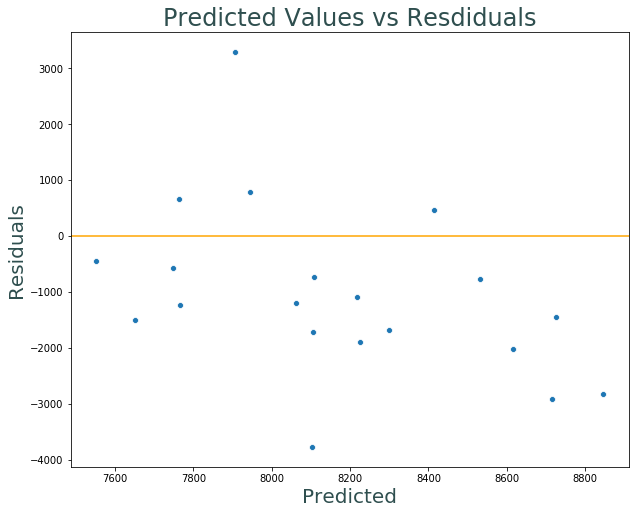

In [42]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 4 Conclusion

### Linear Regression - Phase 2

'final_fused_monthly.csv' dataset includes month level crop and rain data for each block. 

To include the block in the monthly level data, following data transformation steps were executed:
- rain and crop data from various periods were concatenated.
- rain and block(only 'block' feature) datasets are merged to select only those blocks present in blocks dataset
- crop and block(only 'block' feature) datasets are merged to select only those blocks present in blocks dataset
- new rain & crop datasets are transposed to have date as one column and each blocks as one column
- new rain & crop datasets are resampled to have monthly summed rain and crop data for each block
- rain and crop dataset are melted to have one column for all blocks and all 'dates'(months) are repeated for each block.
- rain and crop are merged to have one final dataset with date(month),block,rain,crop.

#### Phase 2 Base Model

Phase 2 uses final_fused_monthly.csv which includes monthly rain and crop data at block level.

In [300]:
# compute mean of the traget variable 'crop'.
df = pd.read_csv("../data/final_fused_monthly.csv")
dfi = df.copy()
dfi['date'] = dfi['date'].apply(lambda x: str(x))
dfi = dfi.sort_values('date')
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset

dfi['y_preds'] =  dfi['crop'] 
crop_mean = dfi['crop'].mean()
dfi['y_preds'] = dfi['y_preds'].apply(lambda x: crop_mean)

y_val = dfi['crop']
y_preds = dfi['y_preds']

print(f'Mean : {crop_mean}')
print(f'RMSE of Base Model:{math.sqrt(metrics.mean_squared_error(y_val,y_preds))}')
scores_df = scores(scores_df,'Linear Regression Base Model','train_val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val,y_preds)),2)}')



Mean : 41.827101586324716
RMSE of Base Model:25.34960725358291


#### Review Target variable Crop

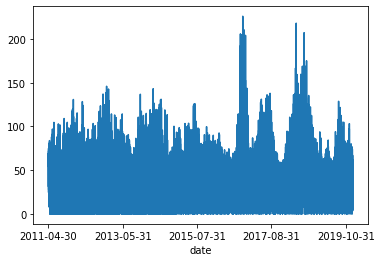

In [301]:
dfi['crop'].plot()

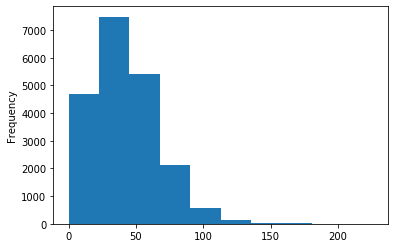

In [302]:
dfi['crop'].plot(kind='hist')

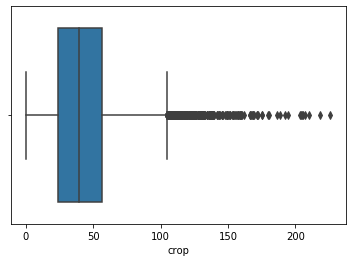

In [303]:
sns.boxplot(dfi['crop'],);

##### Analysis of Outliers and Zero values  in Crop Data  

In [47]:
rain_crop_m[rain_crop_m['crop'] > 100]['crop'].describe()
# there are only 450 rows (out of 21450) with crop more than 150 tonnes a month.

count    450.000000
mean     120.324104
std       22.127974
min      100.070260
25%      105.088517
50%      112.541825
75%      127.750727
max      225.925430
Name: crop, dtype: float64

In [48]:
rain_crop_m.groupby('blk')['crop'].describe()

,count,mean,std,min,25%,50%,75%,max
blk,,,,,,,,
A01,110.0,37.920829,12.492185,13.29261,27.676048,38.528215,46.256898,77.11679
A02,110.0,38.296009,13.897192,7.49842,28.811327,37.625090,48.286552,77.83140
A03,110.0,41.492711,14.164208,10.82470,31.503110,41.408540,50.529353,81.38518
A04,110.0,43.400203,14.400156,8.10227,33.536307,44.241520,52.214512,85.16836
A05,110.0,43.643162,16.226310,12.94336,32.832873,42.439795,51.361728,97.06914
A06,110.0,44.170886,15.129111,9.93940,34.031852,43.488470,51.886827,84.61251
A07,110.0,30.378361,11.281177,8.55157,21.978327,29.325310,37.028693,76.24260
A08,110.0,45.757131,14.265544,10.94206,36.483082,43.918815,53.849785,109.36876
A09,110.0,46.327063,15.852896,10.75993,36.044143,44.928175,54.892590,114.63579


In [49]:
rain_crop_m.groupby('blk')['crop'].max().sort_values()

blk
E06        0.00000
E09        0.00000
ZC01B     11.00877
J03B      13.39512
J05C      15.86561
F07B      16.77460
E07B      18.96087
H02       20.09088
ZM102     20.31511
E08B      23.26277
I08B      24.32752
I01B      29.78423
J09       32.64769
H03B      34.56880
I09       39.31194
I06B      41.23245
E12       53.08940
ZO102     54.35970
A102      56.59992
J04B      58.18482
ZI01      59.07850
K09       61.08352
B08       61.30252
E100      61.97927
H106      63.46297
I07B      65.61117
I08       67.26297
I11       67.53946
J05B      68.35733
I10       68.60397
J08       69.51199
J04A      70.20209
I07A      70.79909
H12       73.67509
ZC102     73.73404
ZN102     74.02178
A07       76.24260
E102      76.48511
I06A      76.66058
A01       77.11679
A02       77.83140
ZJ01      79.12015
F103      79.30837
ZB102     79.56072
A03       81.38518
A100      81.54000
K05       81.62594
F12       82.83078
C10       83.18162
H07       83.54143
F10       83.75709
E01       84.27161
ZA01    

In [50]:
rain_crop_m[rain_crop_m['crop'] == 0]['blk'].unique()

array(['ZC01B', 'E01', 'E02', 'E05', 'E06', 'E09', 'E100', 'E10', 'F05',
       'F06', 'F07B', 'H10', 'H02', 'H03B', 'I01B', 'I08B', 'J05C'],
      dtype=object)

#### Scenerio - 5
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 

In [52]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months


df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months


dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S5','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)

,Model Type,Dataset,Metric,Score
26,Linear Regression lr_S5,Train,R2,0.5309
27,Linear Regression lr_S5,Val,R2,0.348
28,Linear Regression lr_S5,Val,Adj R2,0.2999
29,Linear Regression lr_S5,train,RMSE,17.87
30,Linear Regression lr_S5,Val,RMSE,16.29
31,Linear Regression lr_S5,train,CVal_5,0.4508


In [53]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))

(17381, 211) 17381
(3068, 211) 3068


#### Scenerio - 5  Evaluation

In [54]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

3068

In [55]:
resd_perc = ((resd)/y_val)*100

In [56]:
y_val[y_val == 0].count()

46

In [57]:
y_preds

array([ 0.72300183, 19.85972058, 25.41245495, ..., 60.35306121,
        5.74368621, 65.73782684])

In [58]:
np.sort(resd)

array([-51.71845446, -48.05237559, -47.79346696, ...,  63.8934322 ,
        69.58776942,  71.48974755])

In [59]:
resd.mean()

-5.544115997446533

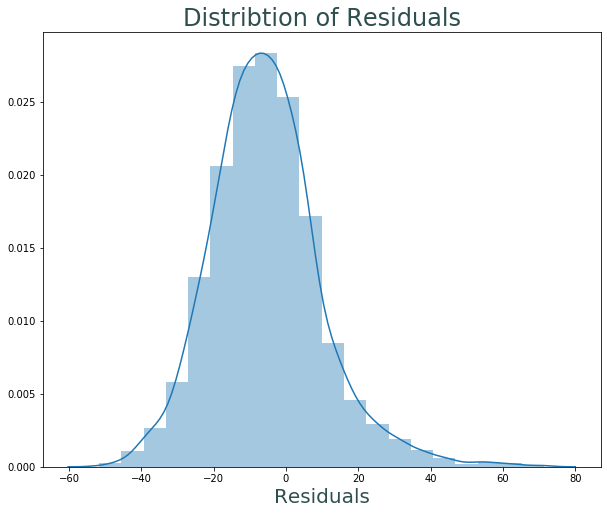

In [60]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

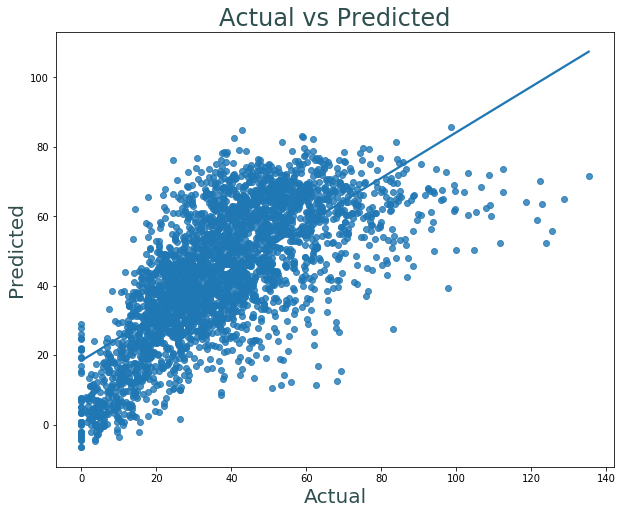

In [61]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

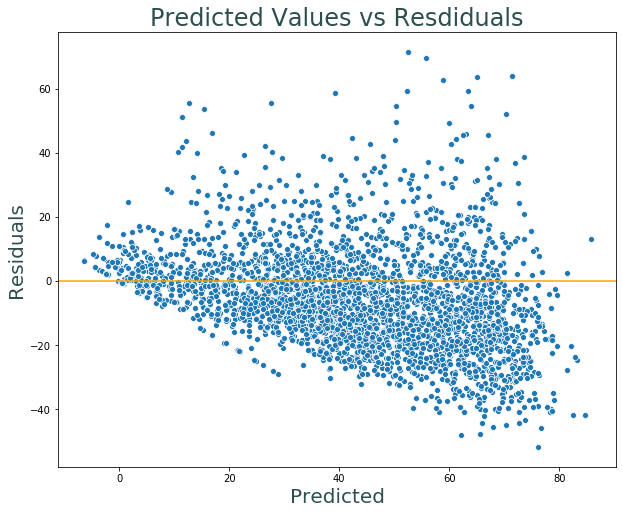

In [62]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 5  Coef Analysis

In [63]:
lr.coef_

array([-1.99113742e+11, -1.99113742e+11, -1.97997690e+11, -1.97997690e+11,
       -1.97997690e+11, -1.97997690e+11, -1.97997690e+11, -1.99113742e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -2.00223444e+11, -2.00223444e+11, -2.00223444e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -2.00223444e+11, -1.99113742e+11,
       -2.00223444e+11, -2.00223444e+11, -2.00223444e+11, -1.97997690e+11,
       -1.99113742e+11, -1.99113742e+11, -2.00223444e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -2.00223444e+11,
       -1.99113742e+11, -2.00223444e+11, -2.00223444e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -1.99113742e+11, -

In [64]:
print(len(X_train.columns),len(lr.coef_))

211 211


In [65]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

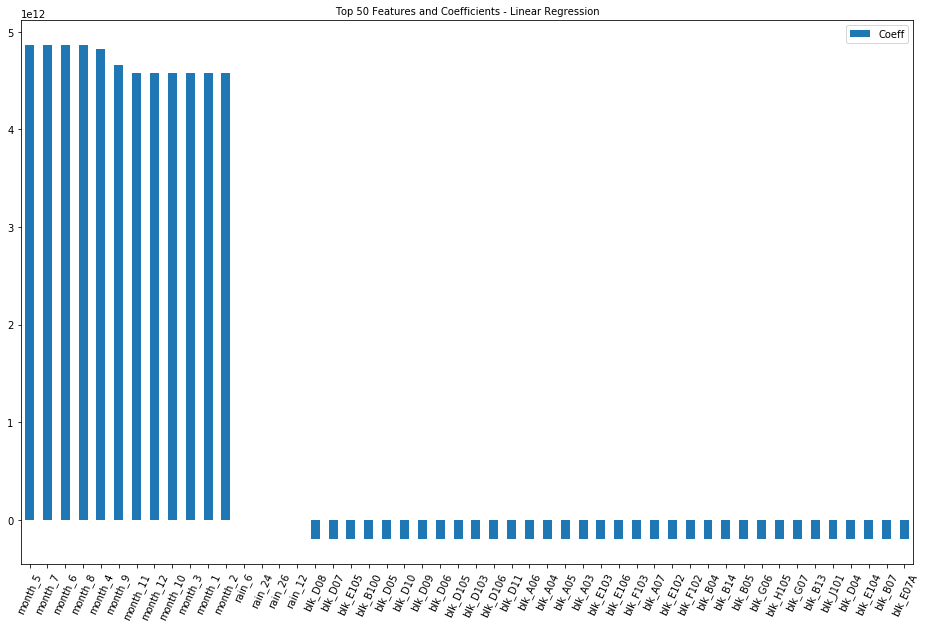

In [66]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

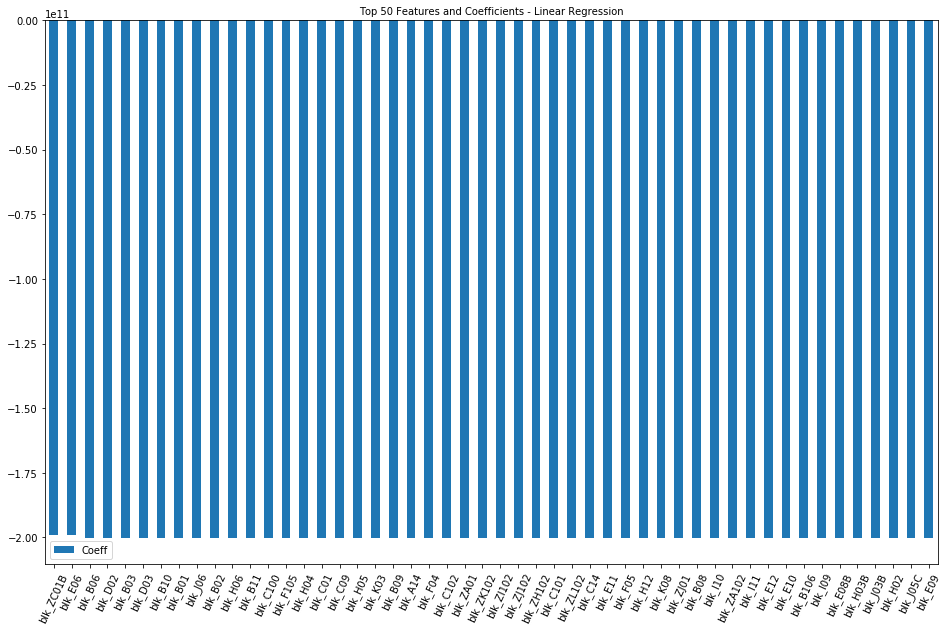

In [67]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

In [68]:
features_coef.tail(10)

,Coeff
month_7,4.864030e+12
month_8,4.864030e+12
month_9,4.656641e+12
month_10,4.577837e+12
month_11,4.577837e+12
month_12,4.577837e+12
rain_6,2.080625e+00
rain_12,-2.988453e-01
rain_24,5.950378e-01
rain_26,-2.481666e-01


#### Scenerio - 5 Lasso Regression 

In [69]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S5','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S5','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)

,Model Type,Dataset,Metric,Score
32,Lasso lassoCV_S5,Train,R2,0.5264
33,Lasso lassoCV_S5,Val,R2,0.378
34,Lasso lassoCV_S5,Val,Adj R2,0.332
35,Lasso lassoCV_S5,train,RMSE,17.96
36,Lasso lassoCV_S5,Val,RMSE,15.91


In [70]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

3068

In [ ]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

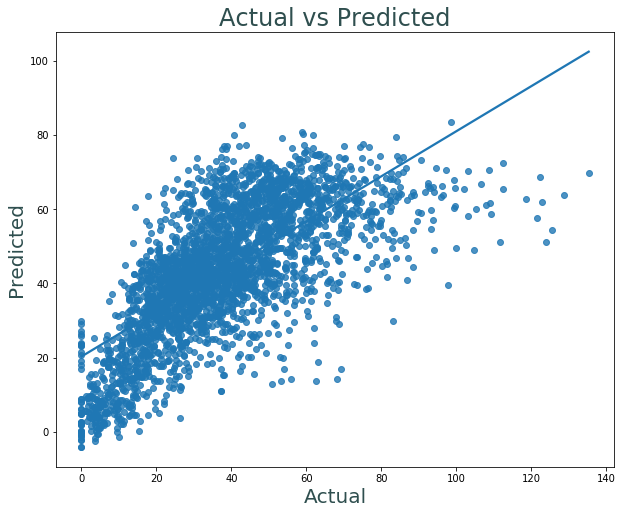

In [71]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

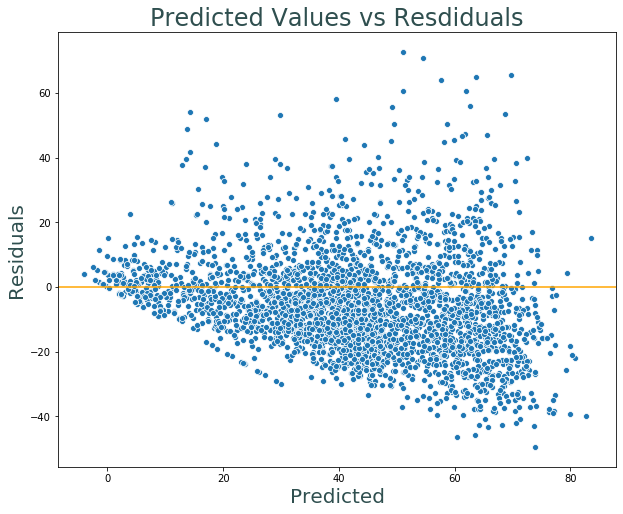

In [72]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [73]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

           Coeff
blk_A03      0.0
blk_A05      0.0
blk_A100    -0.0
blk_B102    -0.0
blk_F08      0.0
blk_F09      0.0
blk_F11     -0.0
blk_H07     -0.0
blk_I06A    -0.0
blk_J05A     0.0
blk_ZS102   -0.0
month_10    -0.0
month_12     0.0
rain_12      0.0
rain_26      0.0
No. of features with zero lassoCV Coef : 15


In [74]:
zero_coef_list = zero_coef.index
zero_coef_list

Index(['blk_A03', 'blk_A05', 'blk_A100', 'blk_B102', 'blk_F08', 'blk_F09', 'blk_F11', 'blk_H07', 'blk_I06A', 'blk_J05A', 'blk_ZS102', 'month_10', 'month_12', 'rain_12', 'rain_26'], dtype='object')

In [75]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

Coeff    196
dtype: int64

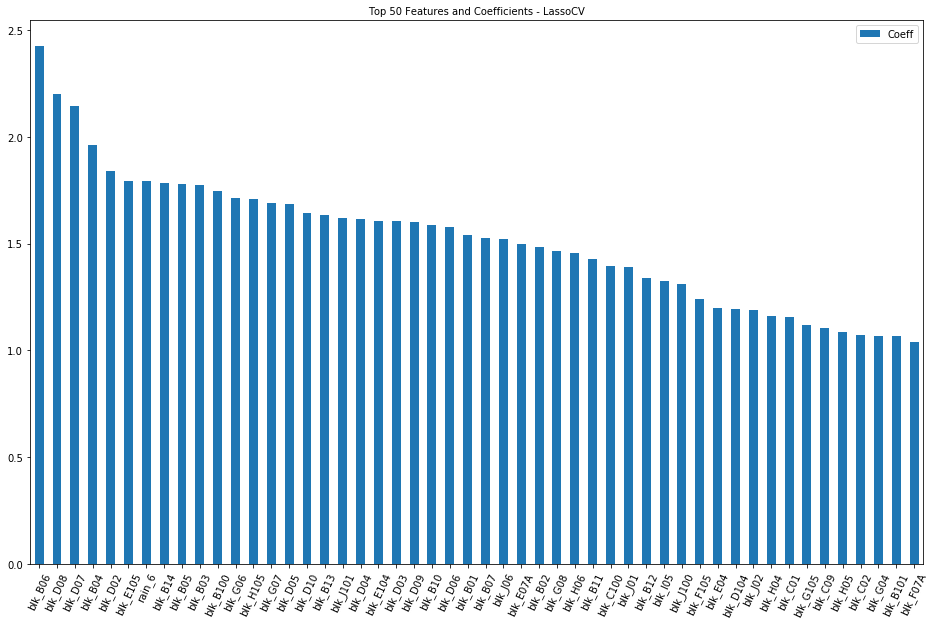

In [76]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

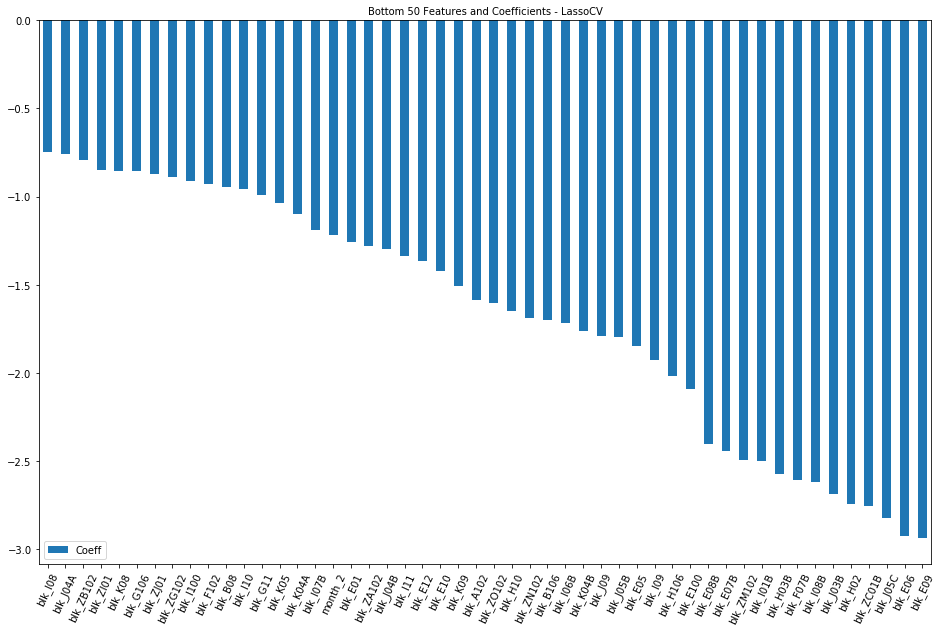

In [77]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [78]:
features_coef.tail(10)

,Coeff
month_7,0.128701
month_8,-0.366957
month_9,-0.737146
month_10,-0.000000
month_11,0.561025
month_12,0.000000
rain_6,1.791356
rain_12,0.000000
rain_24,0.197323
rain_26,0.000000


#### Scenerio - 6
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 


In [304]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months
dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.
dfi.dropna(inplace=True) # drop first 26 rows with null rain_26 column


# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019
# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 127].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S6','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)


,Model Type,Dataset,Metric,Score
191,Linear Regression lr_S6,Train,R2,0.6165
192,Linear Regression lr_S6,Val,R2,0.4269
193,Linear Regression lr_S6,Val,Adj R2,0.373
194,Linear Regression lr_S6,train,RMSE,13.86
195,Linear Regression lr_S6,Val,RMSE,13.8
196,Linear Regression lr_S6,train,CVal_5,0.4951


In [305]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))

(13900, 211) 13900
(2454, 211) 2454


#### Scenerio - 6  Evaluation

In [306]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

2454

###### residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval[['date','blk_eval','crop','crop_preds','variance']].head()

graph = df_eval.groupby(['date'])[['crop','crop_preds']].sum()
##### Plot monthly estate level actaul vs predicted
xf=graph['crop']
yf=graph['crop_preds']
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'monthly Actual vs Predicted at Estate Level'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

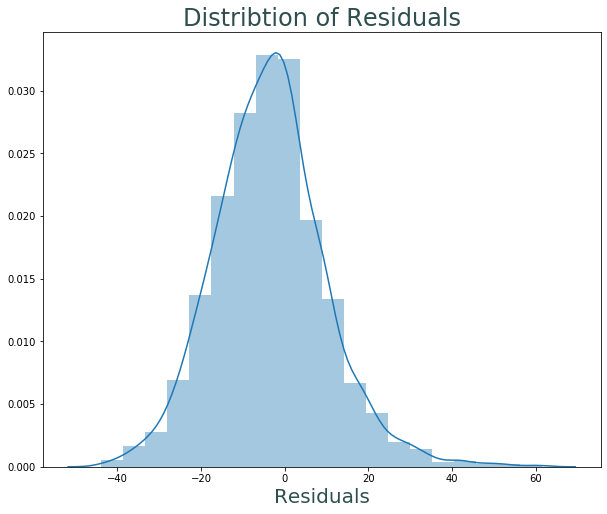

In [84]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

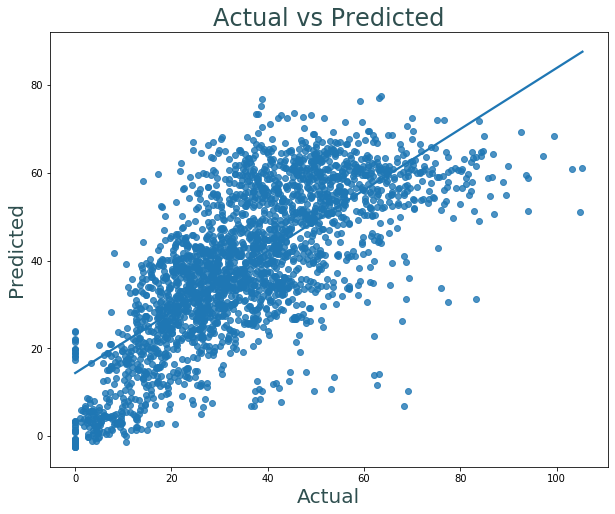

In [85]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

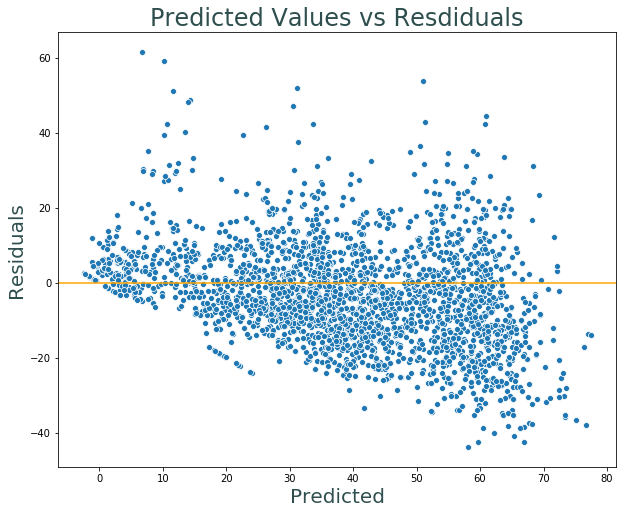

In [86]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio- 6  Coef Analysis

In [87]:
#lr.coef_

In [88]:
print(len(X_train.columns),len(lr.coef_))

211 211


In [89]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

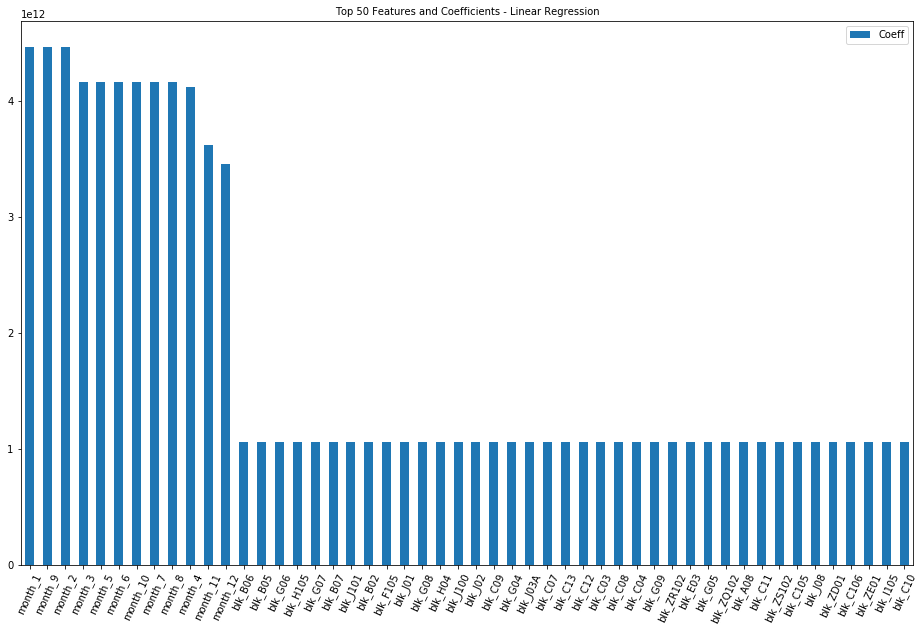

In [90]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

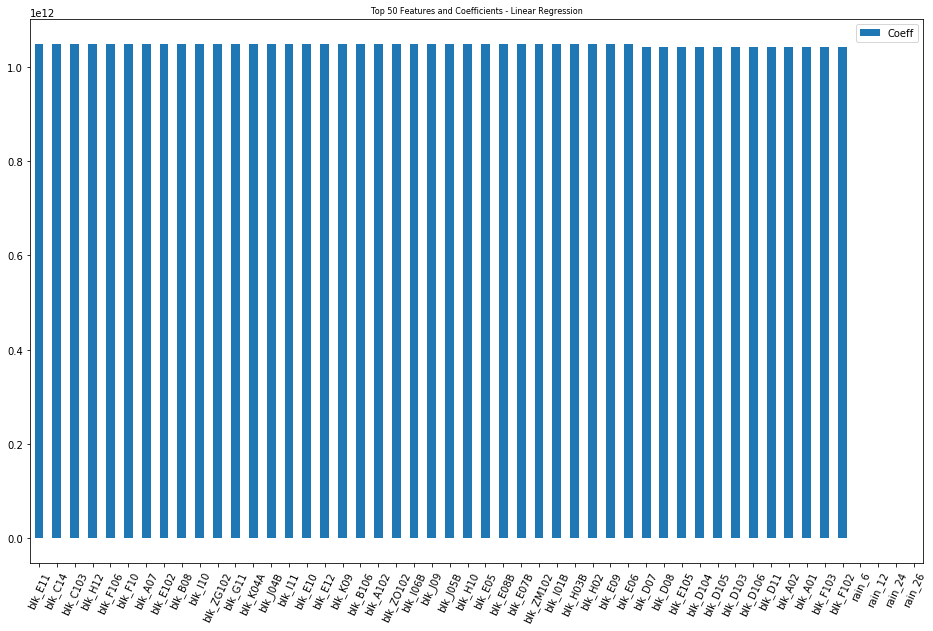

In [91]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 8);
plt.xticks(rotation=65);

In [92]:
features_coef.tail(10)

,Coeff
month_7,4.167737e+12
month_8,4.167737e+12
month_9,4.467058e+12
month_10,4.167737e+12
month_11,3.618402e+12
month_12,3.454676e+12
rain_6,3.331093e-01
rain_12,1.488165e-01
rain_24,-1.419380e-01
rain_26,-3.997226e-01


#### Scenerio - 6 Lasso Regression 

In [93]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S6','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S6','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


,Model Type,Dataset,Metric,Score
43,Lasso lassoCV_S6,Train,R2,0.6148
44,Lasso lassoCV_S6,Val,R2,0.4455
45,Lasso lassoCV_S6,Val,Adj R2,0.3934
46,Lasso lassoCV_S6,train,RMSE,13.89
47,Lasso lassoCV_S6,Val,RMSE,13.58


In [94]:
# residual of LR model on validation dataset
resd = y_val - y_preds
print(f'No. of resd:{len(resd)} No. of actuals {len(y_val)}')
display(y_val[0:5])
display(y_preds[0:5])

No. of resd:2454 No. of actuals 2454


13900    63.38119
13901    52.71568
13902    11.62971
13903    57.99105
13904    35.42728
Name: crop, dtype: float64

array([44.83758783, 50.28904017,  2.611005  , 58.17204647, 34.49826824])

In [ ]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

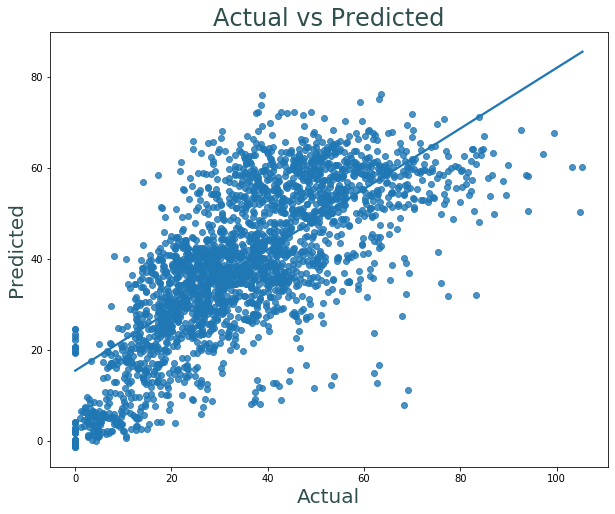

In [95]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

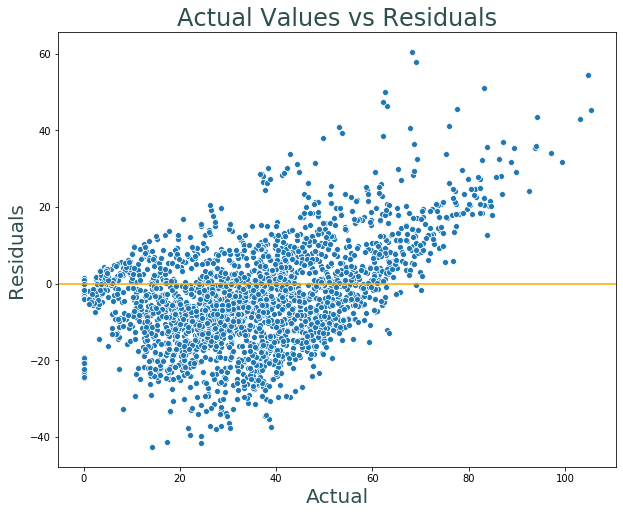

In [96]:
# Plot Actual vs Residuals
xf=y_val
yf=resd
#cf=graph['']
xlabel='Actual'
ylabel='Residuals'
title = 'Actual Values vs Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [97]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

          Coeff
blk_A100   -0.0
blk_F09     0.0
blk_H07     0.0
blk_J05A   -0.0
month_9    -0.0
month_12    0.0
rain_12     0.0
rain_24    -0.0
rain_26    -0.0
No. of features with zero lassoCV Coef : 9


In [98]:
zero_coef_list = zero_coef.index
zero_coef_list

Index(['blk_A100', 'blk_F09', 'blk_H07', 'blk_J05A', 'month_9', 'month_12', 'rain_12', 'rain_24', 'rain_26'], dtype='object')

In [99]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

Coeff    202
dtype: int64

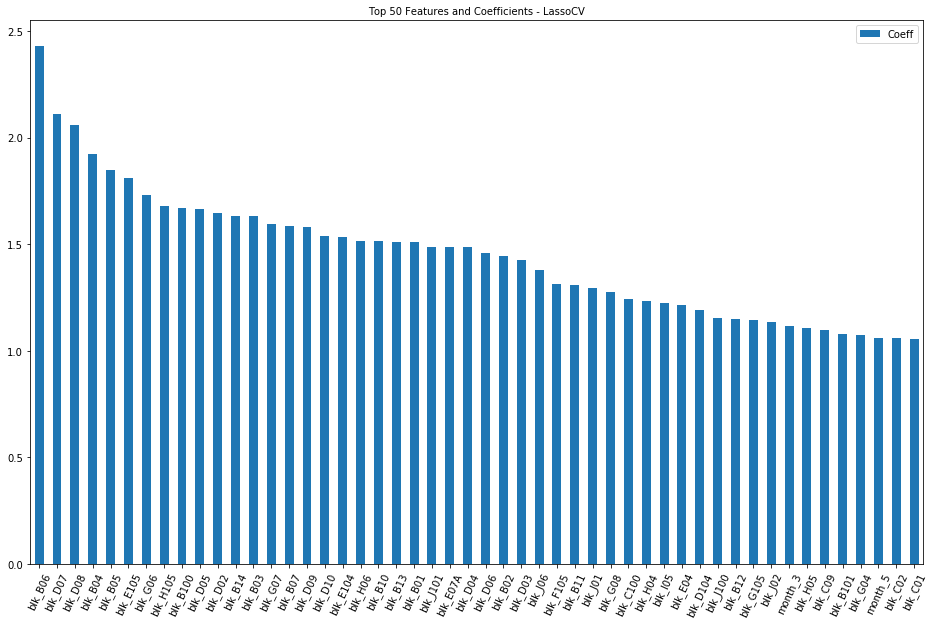

In [100]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

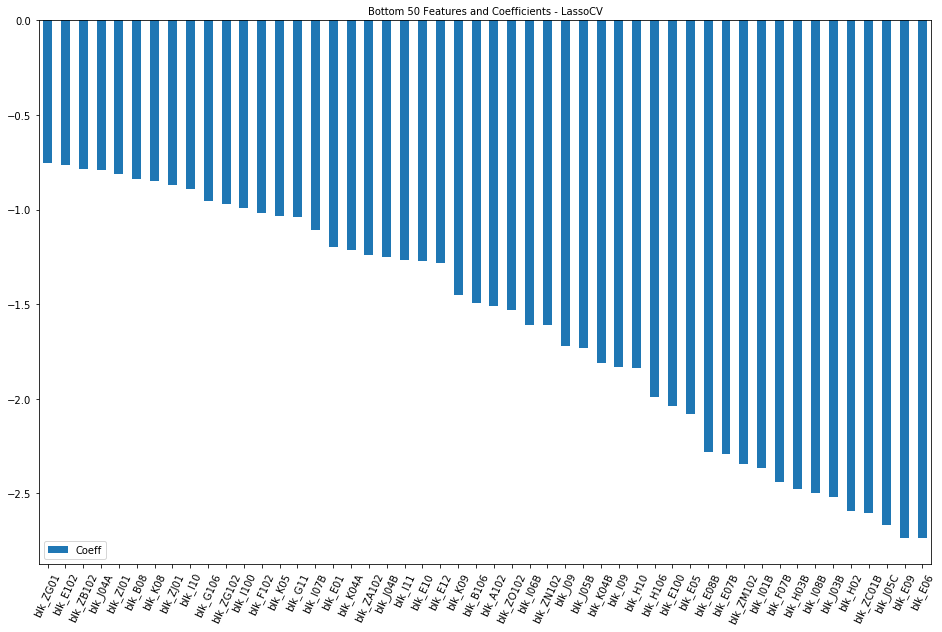

In [101]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [102]:
features_coef.tail(10)

,Coeff
month_7,-0.408427
month_8,-0.603750
month_9,-0.000000
month_10,-0.150689
month_11,-0.283603
month_12,0.000000
rain_6,0.003121
rain_12,0.000000
rain_24,-0.000000
rain_26,-0.000000


#### Scenerio - 7
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 
- Remove observation with zero crop value

In [103]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months
dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.
dfi.dropna(inplace=True) # drop first 26 rows with null rain_26 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019
# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 127].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

#remove rows with zero crop
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] == 0].index,inplace=True)
dfi_m_test.drop(dfi_m_test[dfi_m_test['crop'] == 0].index,inplace=True)

# remove label data - crop from final test dataset
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S5','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)



,Model Type,Dataset,Metric,Score
48,Linear Regression lr_S5,Train,R2,0.5949
49,Linear Regression lr_S5,Val,R2,0.3989
50,Linear Regression lr_S5,Val,Adj R2,0.3401
51,Linear Regression lr_S5,train,RMSE,13.62
52,Linear Regression lr_S5,Val,RMSE,13.8
53,Linear Regression lr_S5,train,CVal_5,0.4644


#### Scenerio - 7  Evaluation

In [104]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

2369

In [105]:
resd_perc = ((resd)/y_val)*100

In [106]:
display(y_val[0:10])
display(y_preds[0:10])

13948    49.66056
13949    44.46350
13950    27.92843
13951     4.01984
13952    21.05549
13953    38.26443
13954    39.99068
13955    18.83282
13956    56.84319
13957    47.39119
Name: crop, dtype: float64

array([21.21092366, 57.00779866, 24.30467366,  1.47654866, 28.36717366,
       29.57029866, 44.85154866, 18.30467366, 33.17967366, 40.08592366])

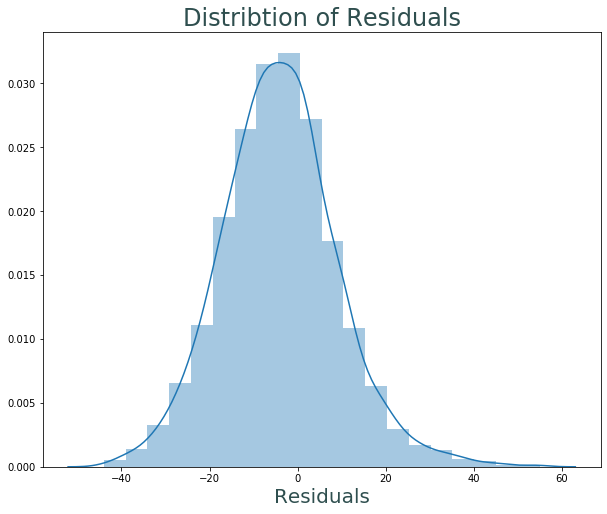

In [107]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

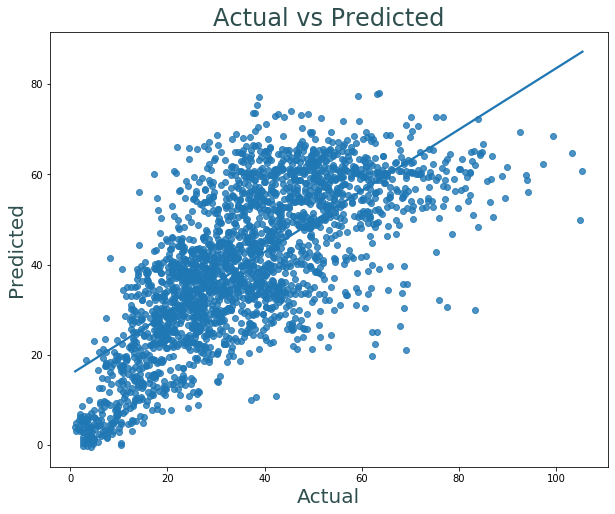

In [108]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

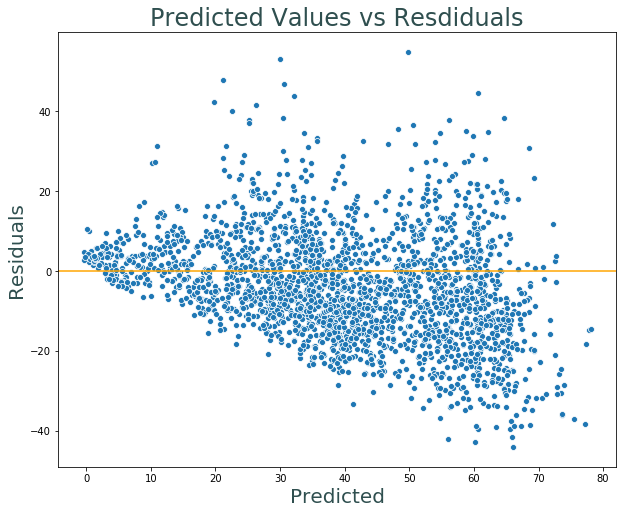

In [109]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio- 7  Coef Analysis

In [110]:
#lr.coef_

In [111]:
print(len(X_train.columns),len(lr.coef_))

211 211


In [112]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

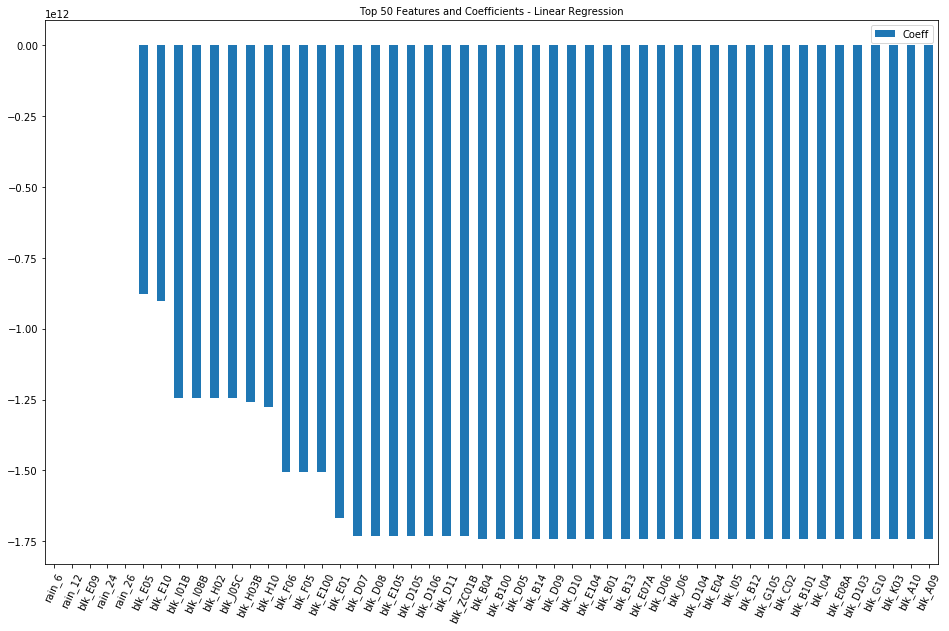

In [113]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

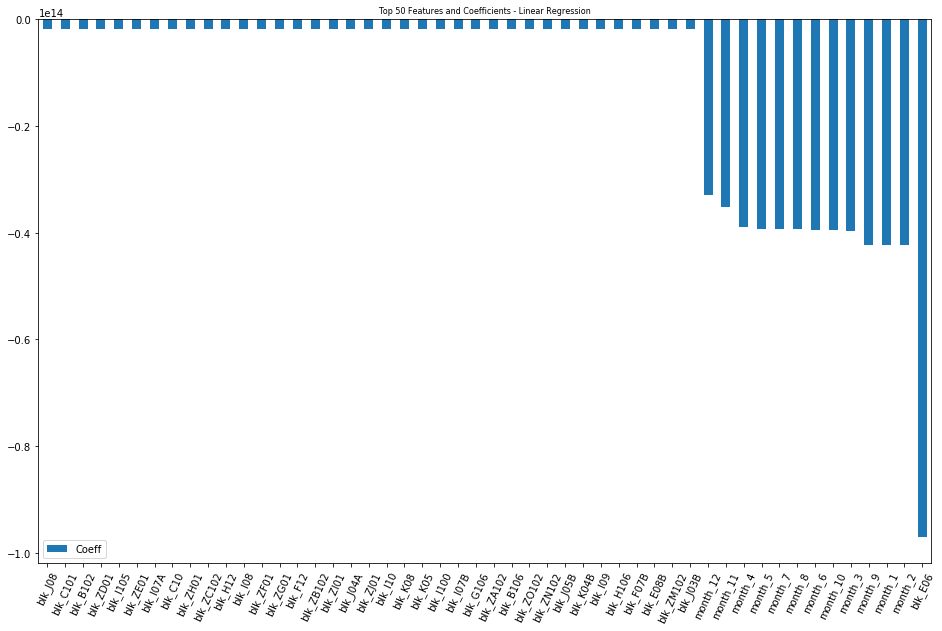

In [114]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 8);
plt.xticks(rotation=65);

In [115]:
features_coef.tail(10)

,Coeff
month_7,-3.933710e+13
month_8,-3.933710e+13
month_9,-4.226196e+13
month_10,-3.951247e+13
month_11,-3.525431e+13
month_12,-3.286081e+13
rain_6,4.389908e-01
rain_12,1.105297e-01
rain_24,-5.990458e-02
rain_26,-5.713673e-01


#### Scenerio - 7 Lasso Regression 

In [116]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S7','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S7','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


,Model Type,Dataset,Metric,Score
54,Lasso lassoCV_S7,Train,R2,0.5956
55,Lasso lassoCV_S7,Val,R2,0.4292
56,Lasso lassoCV_S7,Val,Adj R2,0.3734
57,Lasso lassoCV_S7,train,RMSE,13.61
58,Lasso lassoCV_S7,Val,RMSE,13.45


In [117]:
# residual of LR model on validation dataset
resd = y_val - y_preds
print(f'No. of resd:{len(resd)} No. of actuals {len(y_val)}')
display(y_val[0:5])
display(y_preds[0:5])

No. of resd:2369 No. of actuals 2369


13948    49.66056
13949    44.46350
13950    27.92843
13951     4.01984
13952    21.05549
Name: crop, dtype: float64

array([22.84615524, 56.72021301, 25.58655046,  3.18578064, 29.38929444])

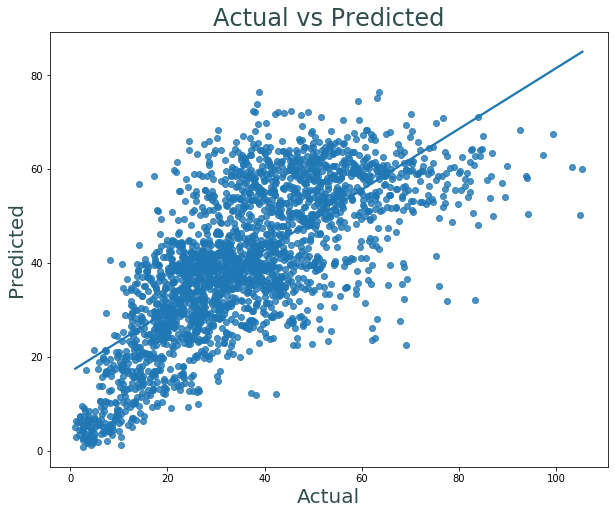

In [118]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [119]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

           Coeff
blk_A03     -0.0
blk_A05      0.0
blk_D11      0.0
blk_E06      0.0
blk_E09      0.0
blk_F05      0.0
blk_H07     -0.0
blk_I06A    -0.0
blk_ZF102    0.0
month_9     -0.0
month_12     0.0
rain_6       0.0
rain_12      0.0
rain_24     -0.0
No. of features with zero lassoCV Coef : 14


In [120]:
zero_coef_list = zero_coef.index
zero_coef_list

Index(['blk_A03', 'blk_A05', 'blk_D11', 'blk_E06', 'blk_E09', 'blk_F05', 'blk_H07', 'blk_I06A', 'blk_ZF102', 'month_9', 'month_12', 'rain_6', 'rain_12', 'rain_24'], dtype='object')

In [121]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

Coeff    197
dtype: int64

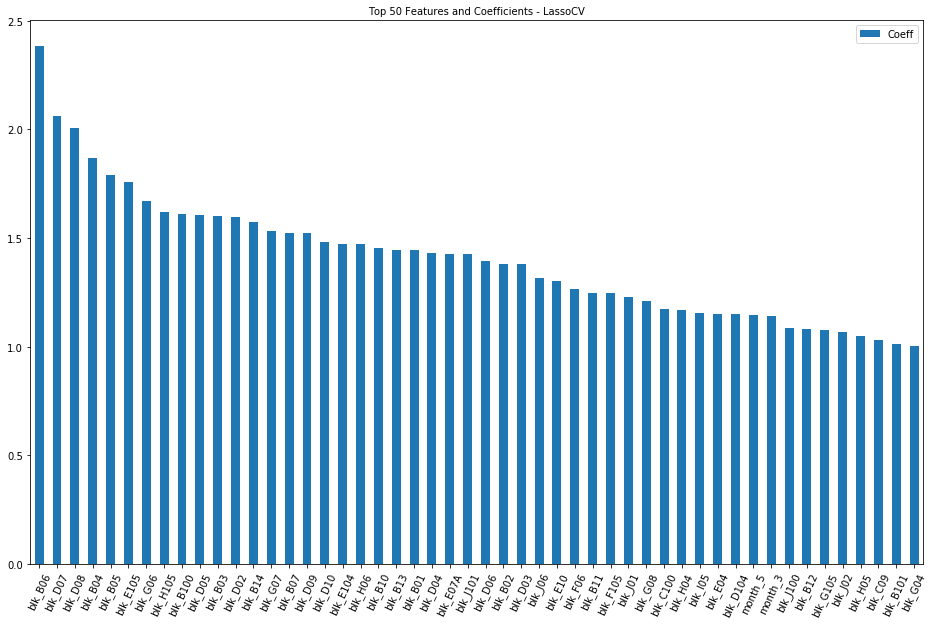

In [122]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

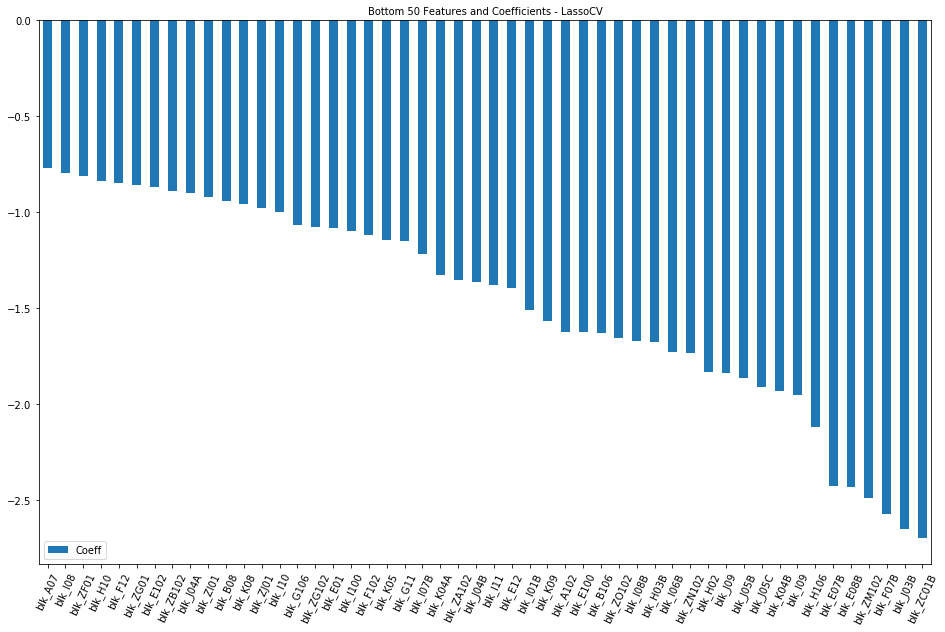

In [123]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [124]:
features_coef.tail(10)

,Coeff
month_7,-0.391346
month_8,-0.596681
month_9,-0.000000
month_10,-0.164960
month_11,-0.260319
month_12,0.000000
rain_6,0.000000
rain_12,0.000000
rain_24,-0.000000
rain_26,-0.010466


#### Scenerio - 9

- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 
- not removing observations with zero crop
- Use area, no of palms, age, class proportion
- compute age as of the month of the each crop data observation

In [308]:
#load final fused dataset
blocks = pd.read_csv("../data/blocks.csv")
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")

# merge with blocks to get block's static features
df = pd.merge(df, blocks,
                how='left', 
                left_on = 'blk', 
                right_on = 'blk', 
                copy=False)


df['mth_of_plant'] = df['mth_of_plant'].apply(lambda x: str(x))
df['mth_of_plant'] = pd.to_datetime(df['mth_of_plant'],yearfirst=True,format="%Y/%m/%d")
    
# compute age as of the month year and month of the crop.
for i in df.index:
    difference = relativedelta.relativedelta(pd.to_datetime(df.loc[i]['date']), 
                                             pd.to_datetime(df.loc[i]['mth_of_plant']))
    months = difference.years * 12 + difference.months
    df.at[i,'age'] = months

#Drop features not required for modeling 
df.drop(['plant_mat','mth_of_plant','syp1_ha','syp2_ha','syp3_ha', 'syp4_ha','syp5_ha','density'],
        axis=1,inplace=True)

# create one hot-encoded blocks
df['blk_eval'] = df['blk'] # keep copy of block name for evaluation of the model
df = pd.get_dummies(df, columns=['blk'],drop_first=False) 

# add new feature month
df['month'] = df['date'].dt.month 
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift 
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift 
dfi['rain_14'] = dfi['rain'].shift(24) # creating new feature with shift 
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift
dfi.drop('rain',axis=1,inplace=True) # drop rain feature
dfi.dropna(inplace=True) # drop rows with NaN due to shifting of rain
dfi['date'] = dfi.index 


# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 120].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

#remove rows with zero crop
#dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] == 0].index,inplace=True)
#dfi_m_test.drop(dfi_m_test[dfi_m_test['crop'] == 0].index,inplace=True)


# assign predictors and target variables
y = dfi_m_train['crop']

# split train data into train and validation datasets
df_train,df_val,y_train,y_val = train_test_split(dfi_m_train,y,test_size=0.15,shuffle=False)

X_train = df_train.drop(['crop','date','blk_eval'],axis=1)
X_val = df_val.drop(['crop','date','blk_eval'],axis=1)

# remove label data - crop and other features needed for evaluation from final test dataset
dfi_m_test.drop(['crop','date','blk_eval'],axis=1,inplace=True)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S9','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)




,Model Type,Dataset,Metric,Score
197,Linear Regression lr_S9,Train,R2,0.6527
198,Linear Regression lr_S9,Val,R2,0.347
199,Linear Regression lr_S9,Val,Adj R2,0.2803
200,Linear Regression lr_S9,train,RMSE,13.01
201,Linear Regression lr_S9,Val,RMSE,14.69
202,Linear Regression lr_S9,train,CVal_5,0.5372


#### Scenerio - 9 Evaluation

In [333]:
# residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval['var_perc'] = ((df_eval['crop'] - df_eval['crop_preds'])/df_eval['crop'])*100
df_eval[['date','blk_eval','crop','crop_preds','variance','var_perc']].describe()

2366 2366 2366


,crop,crop_preds,variance,var_perc
count,2366.000000,2366.000000,2366.000000,2366.000000
mean,35.326150,31.581329,3.744821,NaN
std,18.182574,17.286564,13.496451,NaN
min,0.000000,-11.011283,-36.419595,-inf
25%,22.417118,20.025892,-5.124913,-15.950110
50%,33.975800,31.838619,3.218649,10.205546
75%,47.106447,46.184400,11.517317,34.501138
max,105.365840,70.073886,70.632534,inf


In [332]:

df_eval.groupby(['date','blk_eval'])[['crop','crop_preds','variance','var_perc']].sum().sort_values(by=['var_perc','blk_eval'],ascending=False).head(500)


,,crop,crop_preds,variance,var_perc
date,blk_eval,,,,
2018-12-31,E09,0.00000,-3.571522,3.571522,inf
2019-01-31,E09,0.00000,-3.616009,3.616009,inf
2019-02-28,E09,0.00000,-4.875538,4.875538,inf
2019-03-31,E09,0.00000,-2.338007,2.338007,inf
2019-04-30,E09,0.00000,-4.442317,4.442317,inf
2019-05-31,E09,0.00000,-4.936153,4.936153,inf
2019-06-30,E09,0.00000,-8.969624,8.969624,inf
2019-07-31,E09,0.00000,-10.990861,10.990861,inf
2019-09-30,E09,0.00000,-9.910263,9.910263,inf


In [327]:

df_eval.groupby(['blk_eval'])[['crop','crop_preds','variance','var_perc']].sum().sort_values(by='var_perc',ascending=False).head(50)


,crop,crop_preds,variance,var_perc
blk_eval,,,,
E09,0.00000,-77.700883,77.700883,inf
E06,0.00000,-77.945953,77.945953,inf
J05C,50.94399,-63.196967,114.140957,2746.578786
ZC01B,61.06270,-54.932992,115.995692,2574.581061
J03B,44.19208,-38.297201,82.489281,2524.291711
F07B,54.75587,-38.879808,93.635678,2486.120866
H02,96.88715,-53.519071,150.406221,1902.995664
ZM102,75.44267,-21.795399,97.238069,1675.795718
E07B,75.33486,-16.042082,91.376942,1613.968999


In [271]:
graph = df_eval.groupby(['date'])[['crop','crop_preds']].sum()

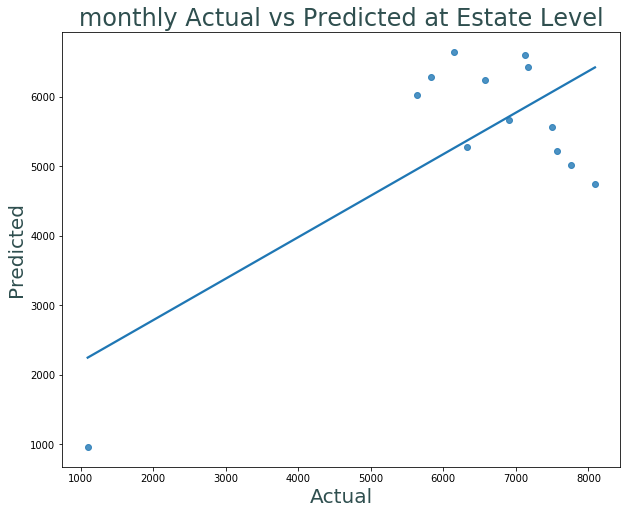

In [272]:
# Plot monthly estate level actaul vs predicted
xf=graph['crop']
yf=graph['crop_preds']
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'monthly Actual vs Predicted at Estate Level'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [273]:
dfi_m_train.columns

Index(['crop', 'area_ha', 'no_of_palms', 'syp1_prop', 'syp2_prop', 'syp3_prop', 'syp4_prop', 'syp5_prop', 'age', 'blk_eval',
       ...
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain_1', 'rain_2', 'rain_3', 'date'], dtype='object', length=221)

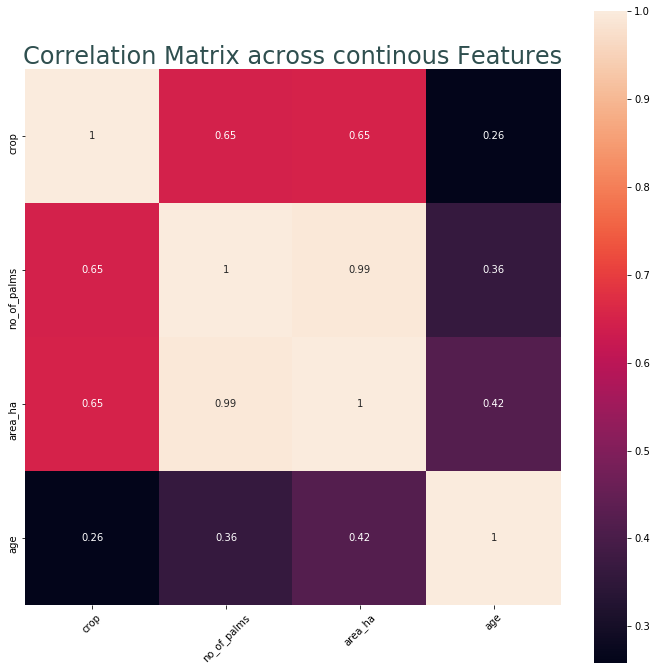

In [276]:
nums_df = dfi_m_train[['crop','no_of_palms','area_ha','age']]
# stores cross columns correlation matrix of continous features in final_corr dataframe
final_corr = nums_df.corr()
# create Seaborn heat map for cross columns correlation matrix stored within final_corr object.
fig, ax = plt.subplots(figsize=(12,12));
ax = sns.heatmap(final_corr, annot=True,square=True);
ax.set_title("Correlation Matrix across continous Features",color=my_title_col, fontsize = my_title_font);
plt.xticks(rotation=45);

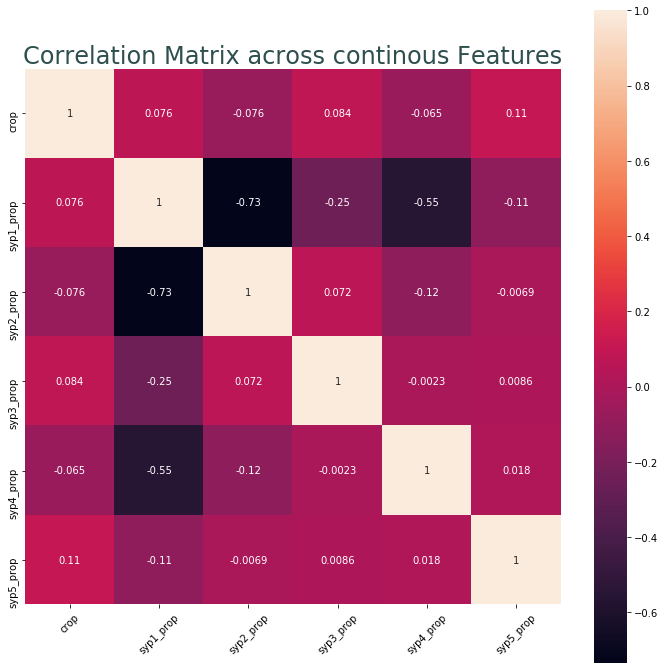

In [278]:
nums_df = dfi_m_train[['crop','syp1_prop', 'syp2_prop', 'syp3_prop', 'syp4_prop', 'syp5_prop']]
# stores cross columns correlation matrix of continous features in final_corr dataframe
final_corr = nums_df.corr()
# create Seaborn heat map for cross columns correlation matrix stored within final_corr object.
fig, ax = plt.subplots(figsize=(12,12));
ax = sns.heatmap(final_corr, annot=True,square=True);
ax.set_title("Correlation Matrix across continous Features",color=my_title_col, fontsize = my_title_font);
plt.xticks(rotation=45);

In [279]:
resd_perc = ((resd)/y_val)*100

In [280]:
display(y_val[0:10])
display(y_preds[0:10])

13423    35.20718
13424    59.30932
13425    51.90107
13426    41.30265
13427    17.60082
13428    35.29730
13429    48.95060
13430    27.50575
13431    16.21661
13432    39.24722
Name: crop, dtype: float64

array([35.39301272, 58.73676272, 49.98676272, 43.65082522, 12.17426272,
       29.70551272, 45.41645022, 13.60395022,  9.89301272, 50.41645022])

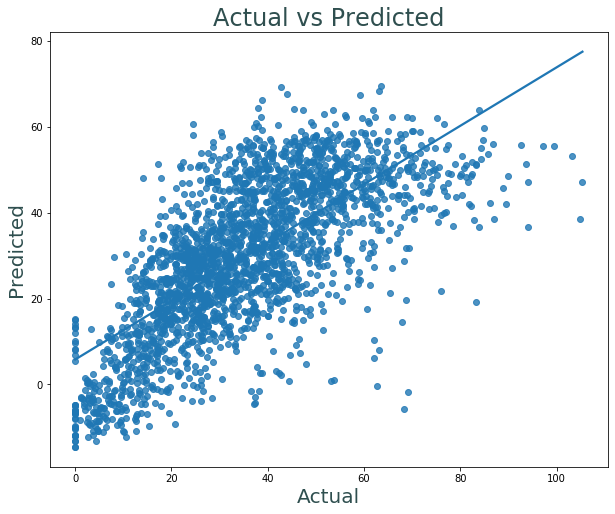

In [281]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

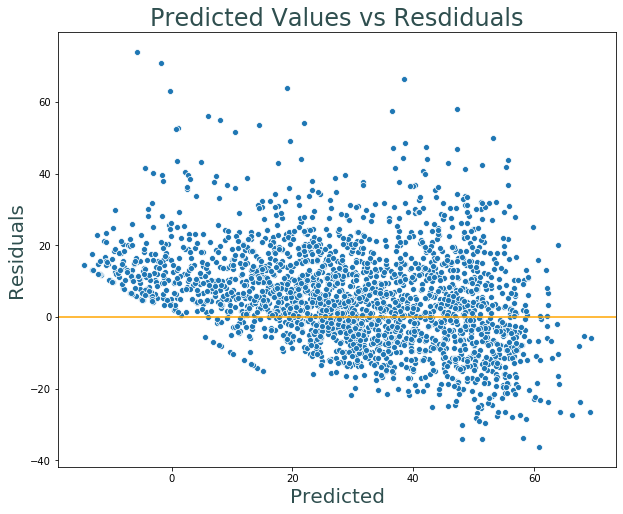

In [282]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio- 9  Coef Analysis

In [283]:
#lr.coef_

In [284]:
print(len(X_train.columns),len(lr.coef_))

218 218


In [311]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

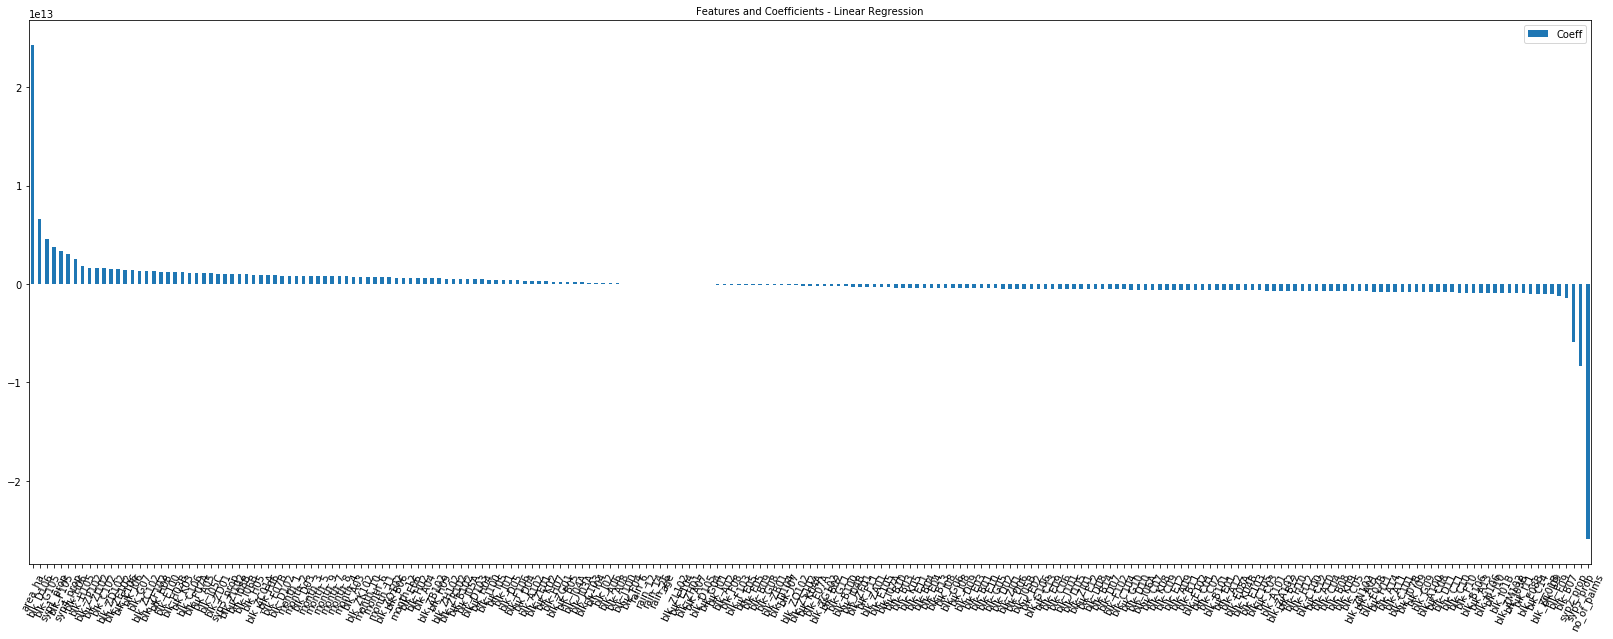

In [312]:
features_coef.sort_values('Coeff',ascending=False).plot(kind='bar',figsize=(28,10));
plt.title('Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

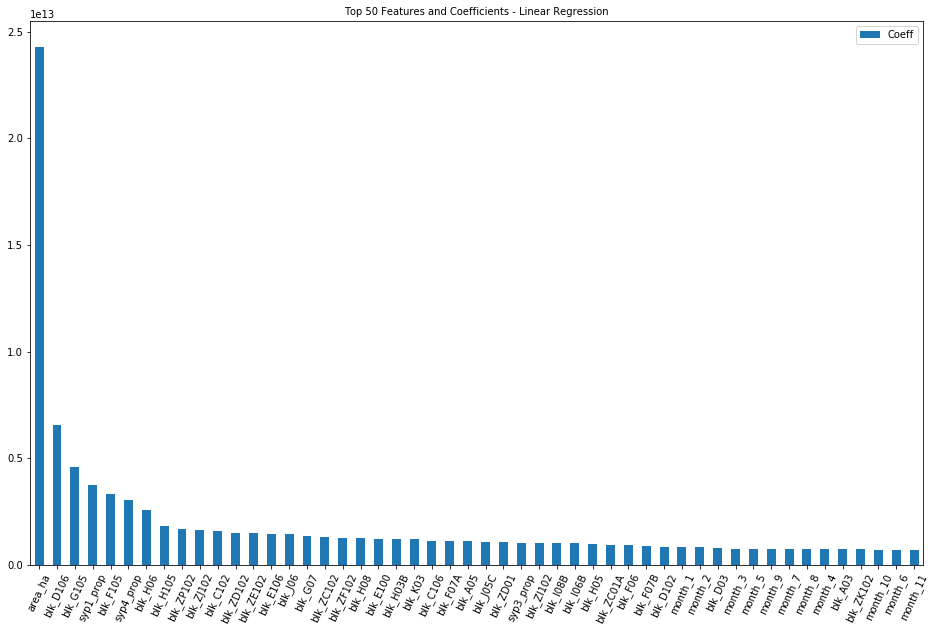

In [313]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

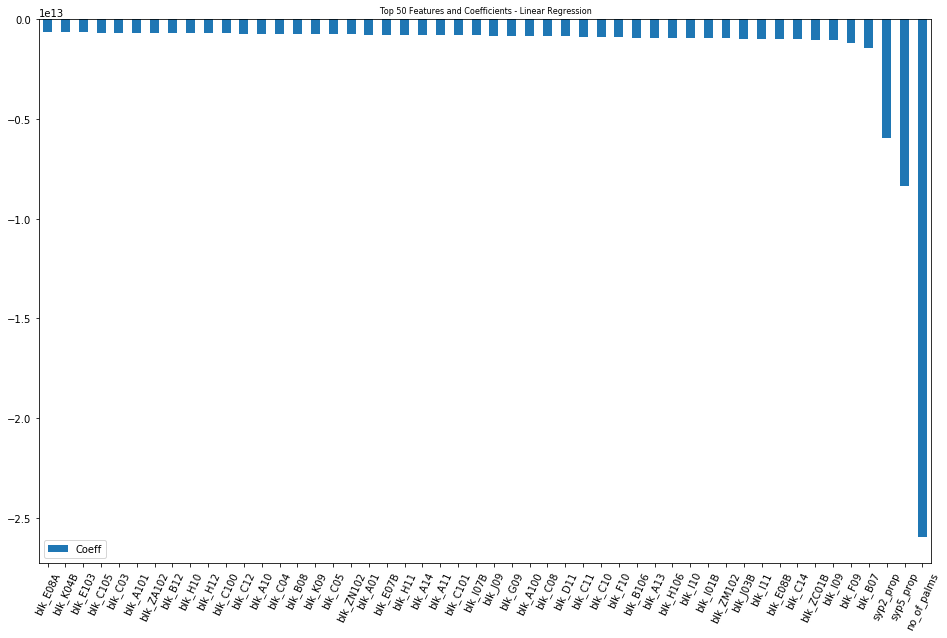

In [314]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 8);
plt.xticks(rotation=65);

In [317]:
features_coef.head()

,Coeff
area_ha,2.428509e+13
no_of_palms,-2.595584e+13
syp1_prop,3.759067e+12
syp2_prop,-5.939914e+12
syp3_prop,1.027981e+12


#### Scenerio - 9 Lasso Regression 

In [310]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S9','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S9','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


,Model Type,Dataset,Metric,Score
203,Lasso lassoCV_S9,Train,R2,0.6508
204,Lasso lassoCV_S9,Val,R2,0.4066
205,Lasso lassoCV_S9,Val,Adj R2,0.346
206,Lasso lassoCV_S9,train,RMSE,13.04
207,Lasso lassoCV_S9,Val,RMSE,14.0


In [291]:
# residual of LR model on validation dataset
# residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval[['date','blk_eval','crop','crop_preds','variance']].head()

2369 2369 2369


,date,blk_eval,crop,crop_preds,variance
13423,2018-11-30,ZD102,35.20718,35.986098,-0.778918
13424,2018-11-30,E105,59.30932,59.545827,-0.236507
13425,2018-11-30,G105,51.90107,51.175211,0.725859
13426,2018-11-30,G10,41.30265,44.881728,-3.579078
13427,2018-11-30,K09,17.60082,13.735390,3.865430


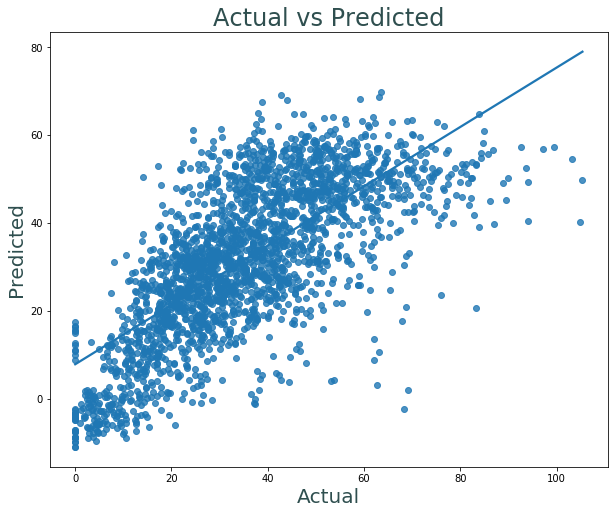

In [293]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

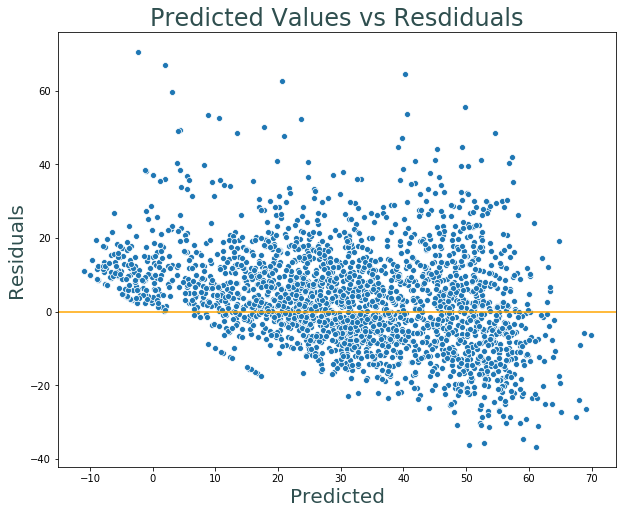

In [294]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

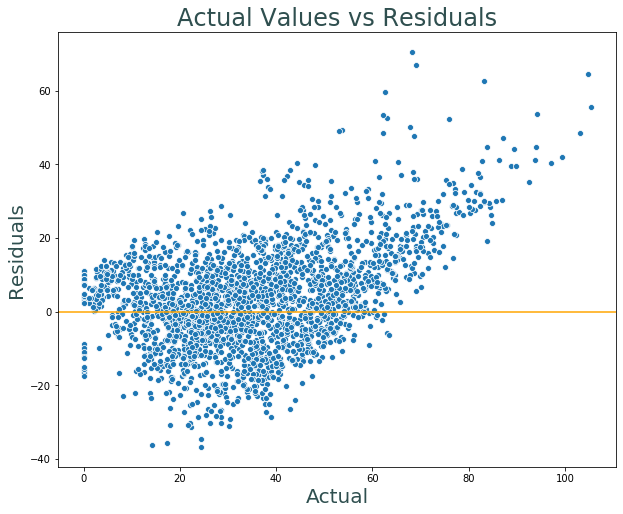

In [295]:
# Plot Actual vs Residuals
xf=y_val
yf=resd
#cf=graph['']
xlabel='Actual'
ylabel='Residuals'
title = 'Actual Values vs Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [296]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

             Coeff
no_of_palms    0.0
syp2_prop     -0.0
syp3_prop      0.0
syp5_prop     -0.0
blk_A102      -0.0
blk_B03        0.0
blk_C06       -0.0
blk_C08       -0.0
blk_D03        0.0
blk_D10       -0.0
blk_D102      -0.0
blk_E04       -0.0
blk_E105       0.0
blk_F07A       0.0
blk_F106      -0.0
blk_I04        0.0
blk_I08        0.0
blk_I105       0.0
blk_ZA102     -0.0
blk_ZB102     -0.0
blk_ZM102      0.0
blk_ZO102     -0.0
month_2        0.0
month_11      -0.0
No. of features with zero lassoCV Coef : 24


In [ ]:
zero_coef_list = zero_coef.index
zero_coef_list

In [ ]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

In [ ]:
selected_feat_coef.plot(kind='bar',figsize=(30,10));
plt.title('Selected Features and Coefficients - LassoCV',fontsize = 15);
plt.xticks(rotation=65);

In [ ]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [ ]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [ ]:
features_coef.tail(10)

In [ ]:
scores_df['Score'] = scores_df['Score'].astype(float)
scores_df[scores_df['Metric'] == 'RMSE'].sort_values(by='Score')